In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import scipy
from sklearn import preprocessing

In [26]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed.csv", sep=",")

In [27]:
attacks = preprocessing.normalize(attacks.to_numpy(), norm="max", axis=0)

# swap sport to front
attacks[:, [0, 1]] = attacks[:, [1, 0]]
# swap dport to after sport
attacks[:, [1, 2]] = attacks[:, [2, 1]]
# swap protocols to after dport
attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

# should probably add batch and shuffle

batch_size = 64
num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
train_dataset = attacks[:int(np.floor(attacks.shape[0]*3/4))]
# train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:10000]).shuffle(10000).batch(batch_size))
# test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]
test_dataset = attacks[:100000]


seq_length = 5
latent_dim = 80

In [28]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [29]:
# encoder

inputs = tf.keras.layers.Input(shape=[num_features,1])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(z)
z = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(z)
codings_mean = tf.keras.layers.Dense(latent_dim)(z) # mu
codings_log_var = tf.keras.layers.Dense(latent_dim)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder

decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
x = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(num_features*1, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([num_features, 1])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# VAE model

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# VAE losses

latent_loss = -0.5 * tf.keras.backend.sum(1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss / float(num_features)))
# variational_ae.add_loss(tf.keras.backend.mean(latent_loss))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
variational_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [30]:
noise_dim = 30

def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = [5, noise_dim], recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(latent_dim, activation="tanh"))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=[latent_dim, 1], recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

In [31]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [32]:
# def wasserstein_loss(y_pred, y_real):
#     return tf.keras.backend.mean(y_pred * y_real)

# def generator_wasserstein_loss(y_pred):
#     return -tf.keras.backend.mean(y_pred)

# class ClipConstraint(tf.keras.constraints.Constraint):
#     def __init__(self, clip_value):
#         self.clip_value = clip_value

In [33]:
# def make_critic(input_shape):
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     const = ClipConstraint(0.01)
#     model = tf.keras.models.Sequential()
#     # model.add(tf.keras.layers.Flatten(input_shape=(input_shape[0]*input_shape[1])))
#     # model.add(tf.keras.layers.LSTM(100, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm1"))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm2"))
#     model.add(tf.keras.layers.Dense(250, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const))

#     model.add(tf.keras.layers.Dense(200, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, name="c_lstm3"))
#     model.add(tf.keras.layers.Dense(150, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(100, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(1, name="c_dense"))
#     # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     # model.compile(loss=wasserstein_loss, optimizer=opt)
#     return model

# def make_generator(output_shape, noise_dim):
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     model = tf.keras.models.Sequential()
#     # model.add(tf.keras.layers.LSTM(100, input_shape=(5, output_shape), kernel_initializer=init, recurrent_dropout=0.4, return_sequences=True))
#     model.add(tf.keras.layers.Dense(100, input_shape=[noise_dim], kernel_initializer=init))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, recurrent_dropout=0.4))
#     model.add(tf.keras.layers.Dense(150, kernel_initializer=init))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(200, kernel_initializer=init))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="tanh", kernel_initializer=init))
#     # model.add(tf.keras.layers.Reshape([output_shape[0], output_shape[1]]))
#     model.add(tf.keras.layers.Dense(output_shape, activation="tanh"))
#     # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     # model.compile(loss=generator_wasserstein_loss, optimizer=opt)
#     return model

# def make_gan(generator, critic):
#     model = tf.keras.models.Sequential()
#     model.add(generator)
#     model.add(critic)
#     opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     model.compile(loss=wasserstein_loss, optimizer=opt)
#     return model

## Step 1: Train autoencoder on real data

In [34]:
# variational_ae.fit(train_dataset, train_dataset, epochs=5, batch_size=64)
variational_ae.fit(train_dataset, train_dataset, epochs=5, batch_size=64)

Epoch 1/5
31151/31151 [==============================] - 30s 949us/step - loss: 0.2449
Epoch 2/5
31151/31151 [==============================] - 29s 944us/step - loss: 0.2194
Epoch 3/5
31151/31151 [==============================] - 30s 949us/step - loss: 0.2157
Epoch 4/5
31151/31151 [==============================] - 29s 947us/step - loss: 0.2141
Epoch 5/5
31151/31151 [==============================] - 29s 938us/step - loss: 0.2132


## Step 2: Train GAN to learn realistic latent vectors

In [35]:
# generator_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
# critic_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

# def train_step(generator, critic, dataset, latent_dim, noise_dim, n_batch=40, n_critic=5):

#     for _ in range(n_critic):

#         """
#         Train critic more often than the generator for WGAN
#         """

#         with tf.GradientTape() as critic_tape:
#             ix = np.random.randint(0, dataset.shape[0], n_batch)
#             # X_real = dataset.numpy()[ix]
#             X_real = dataset[ix]
#             noise = tf.random.normal((n_batch, noise_dim))
#             X_fake = generator(noise, training=True)

#             pred_real = critic(X_real, training=True)
#             pred_fake = critic(X_fake, training=True)

#             c_loss = wasserstein_loss(pred_real, pred_fake)
        

#         critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
#         critic_optimiser.apply_gradients(zip(critic_gradients, critic.trainable_variables))
#     # print(f"Critic loss: {c_loss}")  
    
#     """ 
#     Train generator
#     """

#     with tf.GradientTape() as gen_tape:
#         X_fake = generator(noise, training=True)
#         pred_fake = critic(X_fake, training=True)
#         g_loss = generator_wasserstein_loss(pred_fake)
#         # print(f"Generator loss: {g_loss}")
    
#     generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
#     generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))


#     return c_loss, g_loss

# def train(dataset, n_epochs=2, noise_dim=50, latent_dim=50):

#     generator = make_generator(latent_dim, noise_dim)
#     critic = make_critic((latent_dim, 1))

#     c_losses, g_losses = [], []

#     for i in range(n_epochs):
#         # print(f"Epoch: {i+1}")
#         for batch in dataset:
#             c_loss, g_loss = train_step(generator, critic, batch, latent_dim, noise_dim)
#             c_losses.append(c_loss)
#             g_losses.append(g_loss)
    
#     noise = tf.random.normal((1000, noise_dim))
#     prediction = generator.predict(noise)

#     return c_losses, g_losses, prediction

In [36]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    # noise = tf.random.normal((batch_size, seq_length, num_features))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        noise = tf.random.normal((64, 5, noise_dim))
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [37]:
real_latent_vectors = np.split((variational_encoder(attacks[:20000])[0]).numpy(), 200)
noise = tf.random.normal((batch_size, seq_length, num_features))
latent_vector_dataset = (tf.data.Dataset.from_tensor_slices((variational_encoder(attacks[:20000])[0]).numpy()).shuffle(10000).batch(64))
latent_vector_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 80), dtype=tf.float32, name=None)>

In [38]:
def train(dataset, epochs):
    predictions = np.array([])
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
            dlosses.append(dloss)
            glosses.append(gloss)

        noise = tf.random.normal((64, 5, noise_dim))
        prediction = generator(noise, training=False)
        predictions = np.append(predictions, prediction)

    return predictions, dlosses, glosses

In [39]:
len(real_latent_vectors)

200

In [40]:
# c_losses, g_losses, pred = train(real_latent_vectors, 10, 30, latent_dim)
preds, dlosses, glosses = train(latent_vector_dataset, epochs=10)

In [41]:

# noise_dim = 30
# n_batch = 64
# # create the critic
# critic = make_critic([latent_dim, 1])
# # create the generator
# # generator = make_generator((n_batch, latent_dim))
# generator = make_generator(latent_dim, noise_dim)
# # create the gan
# gan = make_gan(generator, critic)
# # load image data


# real_latent_vectors = variational_encoder(test_dataset)[0]
# epochs = 10
# # train model
# c1_loss, c2_loss, g_loss = train(generator, critic, gan, dataset=test_dataset[:10000], latent_dim=latent_dim, noise_dim=noise_dim, n_epochs=epochs, n_batch=n_batch)

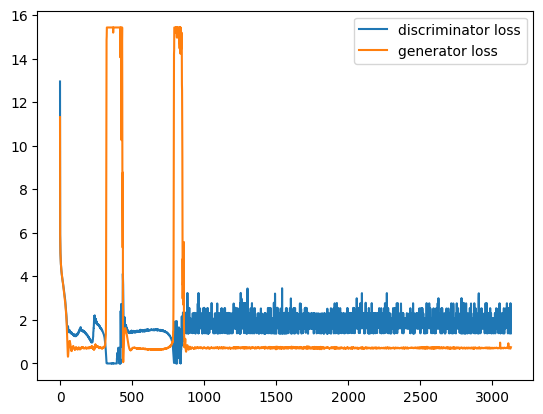

In [42]:
# plt.plot(c_losses, label="critic loss real data")
# plt.plot(g_losses, label="generator")
plt.plot(dlosses, label="discriminator loss")
plt.plot(glosses, label="generator loss")
plt.legend()
plt.show()

## Step 3: Use generator to make latent vectors and decode with decoder

In [43]:
preds = preds.reshape(640, latent_dim)

In [44]:
test_dataset.shape

(100000, 23)

In [45]:
latent_vectors = preds
data = variational_decoder(latent_vectors)
scipy.stats.ks_2samp(test_dataset[:640].reshape(14720,), data.numpy().reshape(14720,))
# data.numpy().shape, test_dataset.shape

KstestResult(statistic=0.836820652173913, pvalue=0.0, statistic_location=0.14391691394658754, statistic_sign=1)

In [46]:
scipy.stats.wasserstein_distance(test_dataset[:640].reshape(14720,), data.numpy().reshape(14720,))

0.2650681650427665

In [47]:
# from sklearn.neighbors import KernelDensity
# kde_gen = KernelDensity(kernel='epanechnikov').fit(data.numpy()[:, 10].reshape(-1, 1))
# kde_dat = KernelDensity(kernel='epanechnikov').fit(test_dataset[:1000, 10].reshape(-1, 1))

# plt.plot(kde_gen.score_samples(data.numpy()[:, 10].reshape(-1, 1)))

In [48]:
# plt.plot(kde_dat.score_samples(test_dataset[:1000, 10].reshape(-1, 1)))